Directory of the tests: `/BGFS/DISASTER/grimast/calibration3arcmin_workflow/catchments/4814/`

Experiments:
* `out_Gv5test5_deapup_MCT_TL_RES/long_term_run/`
* `out_Gv5test5_deapup_MCT_TL_RES/long_term_run_FIXreservoirsmodule/`
* `out_deapup_MCT_TL_RESmapspar0303205_RESfix_RFparam/long_term_run_RESFILL/`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from lisflood_read_plot import *

from lisfloodreservoirs.utils.plots import plot_resops, reservoir_analysis

## Config

In [2]:
PATH_TESTS = Path('Z:/nahaUsers/casadje/GloFASv5/reservoirs/tests')

catchment = '99629'
test = 'out_deapup_MCT_TL_ResCalDEAP/long_term_run'
PATH_RESULTS = PATH_TESTS / catchment / test

# PATH_OBS = Path('Z:/nahaUsers/casadje/datasets/Kazakhstan/reservoirs/timeseries/processed')

## Records

In [3]:
# observed = pd.read_csv(PATH_OBS / 'shardara.csv', parse_dates=True, index_col='date')
# observed.rename(columns={'inflow m3/sec': 'inflow', 'discharge m3/sec': 'outflow', 'volume million/m3': 'filling'}, inplace=True)
# observed.filling /= 6700 # 5200 hm3 according to Kazakhstan

# observed.head()

## Model

### Time series

In [5]:
# files to be read
tss_files = {
    'resfill': 'filling',
    'qresin': 'inflow',
    'qresout': 'outflow',
    # 'withdrawalReservoirsTS': 'withdrawal'
}

# find settings file
try:
    settings_file = list(PATH_RESULTS.glob('*.xml'))[0]
except:
    settings_file = None

# read results
results = {}
for file, variable in tss_files.items():
    df = read_tss(
        tss=PATH_RESULTS / f'{file}.tss',
        xml=settings_file
    )
    df = df.replace(1e31, np.nan).dropna(axis=1, how='all')
    df.columns = df.columns.astype(int)
    results[variable] = df

# reorganize results
results = {
    ID: pd.concat([df[ID] for df in results.values()], axis=1, keys=results.keys())
    for ID in results[list(results)[0]].columns
}

### Reservoir attributes

In [6]:
attributes = []
for txt_file in (PATH_TESTS  / 'tables' / 'new').glob('reservoirs*20250228.txt'):
    print(txt_file)
    attr = pd.read_csv(txt_file, sep='\t', header=None, index_col=0)
    attr.columns = ['_'.join(txt_file.stem.split('_')[2:-1])]
    attr.index.name = 'ID'
    attributes.append(attr)
attributes = pd.concat(attributes, axis=1)
attributes = attributes.loc[results.keys()]

attributes.head()

Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_100yr_inflow_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_avg_inflow_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_capacity_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_env_flow_20250228.txt


,100yr_inflow,avg_inflow,capacity,env_flow
ID,,,,
287,966.8,168.5,19500000000,8.423
288,3387.7,849.7,6700000000,42.483
292,2779.9,673.2,4160000000,33.660
1449,668.8,88.3,2000000000,4.414
1468,115.3,15.2,250000000,0.760


### Reservoir parameters

In [10]:
# parameters = []
# for txt_file in (PATH_TESTS  / 'parameters').glob('reservoirs*.txt'):
#     print(txt_file)
#     par = pd.read_csv(txt_file, sep='\t', header=None, index_col=0)
#     par.columns = ['_'.join(txt_file.stem.split('_')[2:])]
#     par.index.name = 'ID'
#     parameters.append(par)
# parameters = pd.concat(parameters, axis=1)
# parameters = parameters.loc[results.keys()]

parameters = pd.DataFrame(index=attributes.index)
parameters['flood_storage'] = 0.2
parameters['outflow_factor'] = 0.3

parameters.head()

,flood_storage,outflow_factor
ID,,
287,0.2,0.3
288,0.2,0.3
292,0.2,0.3
1449,0.2,0.3
1468,0.2,0.3


### Reservoir limits

In [11]:
limits = pd.DataFrame(index=attributes.index, dtype=float)

limits['Vt'] = 1 # attributes.capacity
limits['Ve'] = 0.8 * limits.Vt + 0.2 * parameters.flood_storage
limits['Vf'] = parameters.flood_storage * limits.Vt
limits['Vc'] = 0.5 * limits.Vf

limits['Qf'] = parameters.outflow_factor *  attributes['100yr_inflow']
limits['Qn'] = attributes.avg_inflow
limits['Qc'] = limits.Qn * limits.Vc / limits.Vf
limits['Qmin'] = attributes.env_flow

limits.head()

,Vt,Ve,Vf,Vc,Qf,Qn,Qc,Qmin
ID,,,,,,,,
287,1,0.84,0.2,0.1,290.04,168.5,84.25,8.423
288,1,0.84,0.2,0.1,1016.31,849.7,424.85,42.483
292,1,0.84,0.2,0.1,833.97,673.2,336.60,33.660
1449,1,0.84,0.2,0.1,200.64,88.3,44.15,4.414
1468,1,0.84,0.2,0.1,34.59,15.2,7.60,0.760


### Analysis

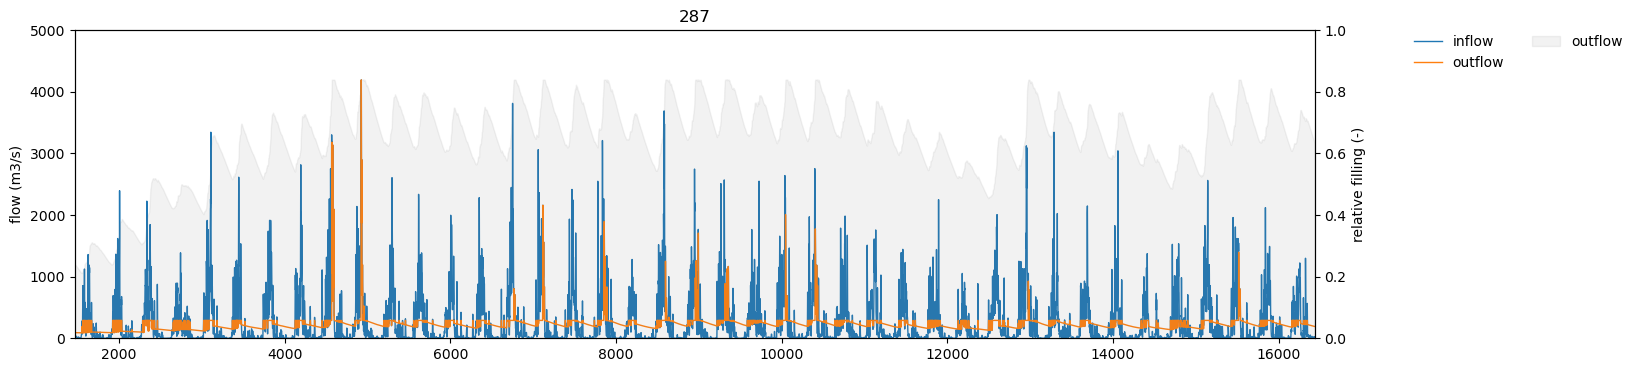

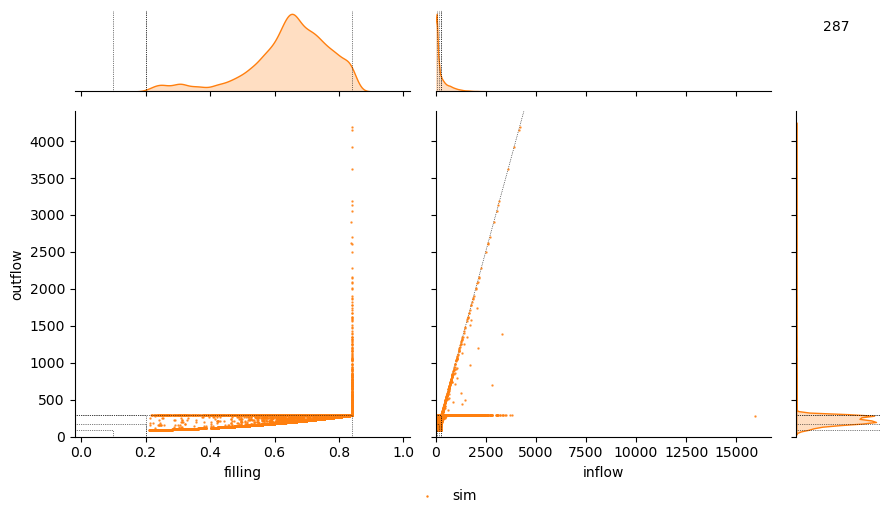

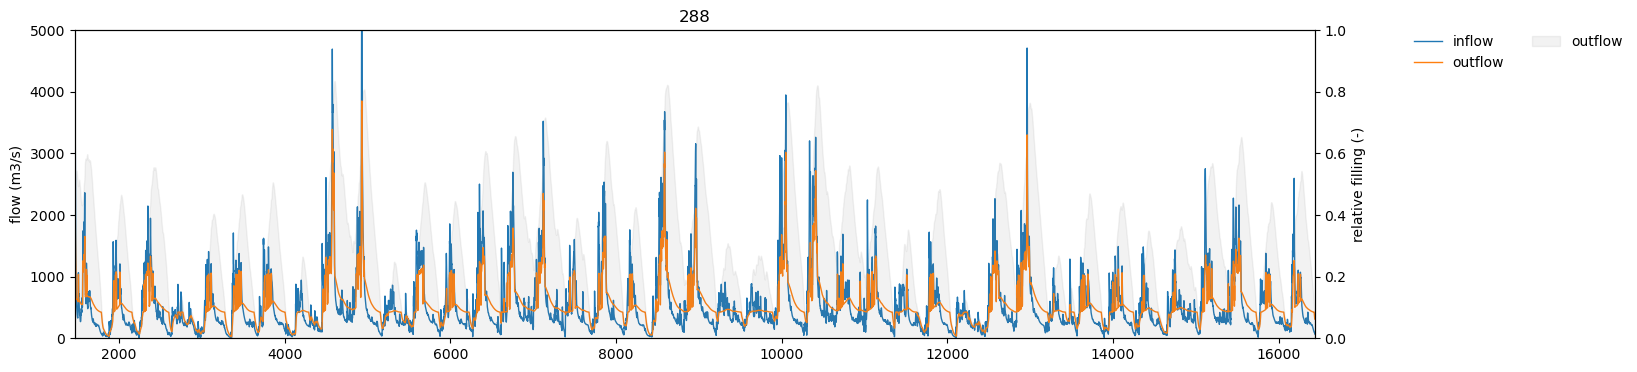

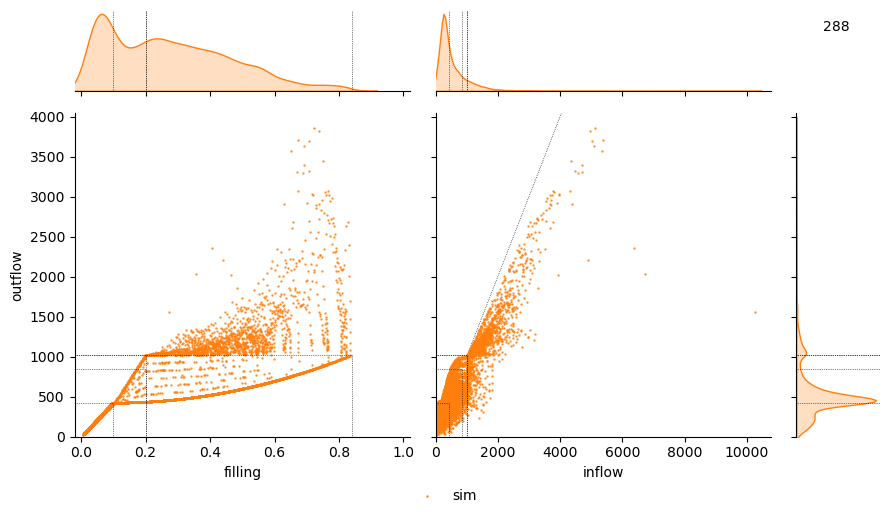

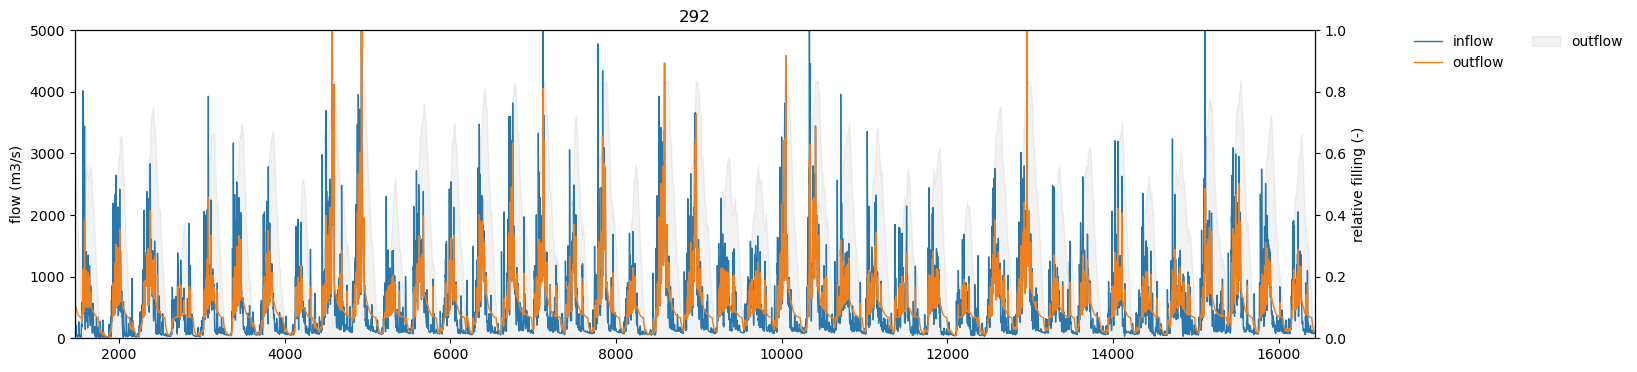

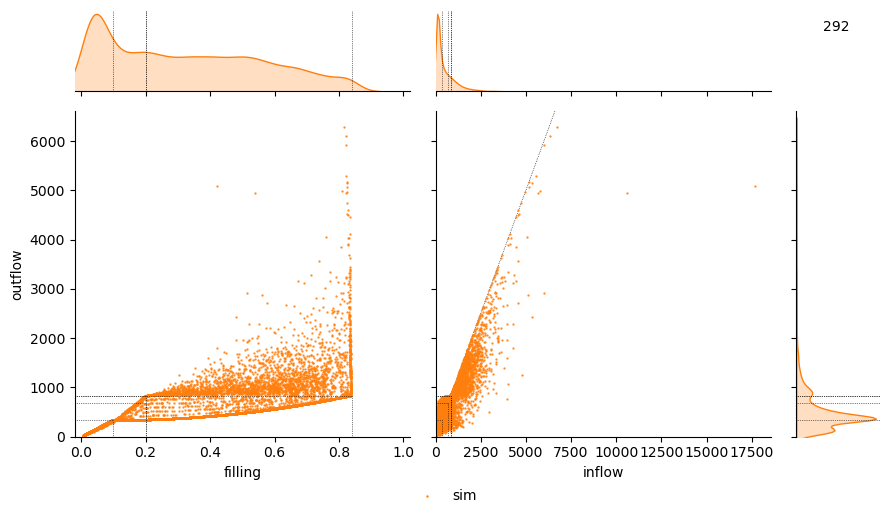

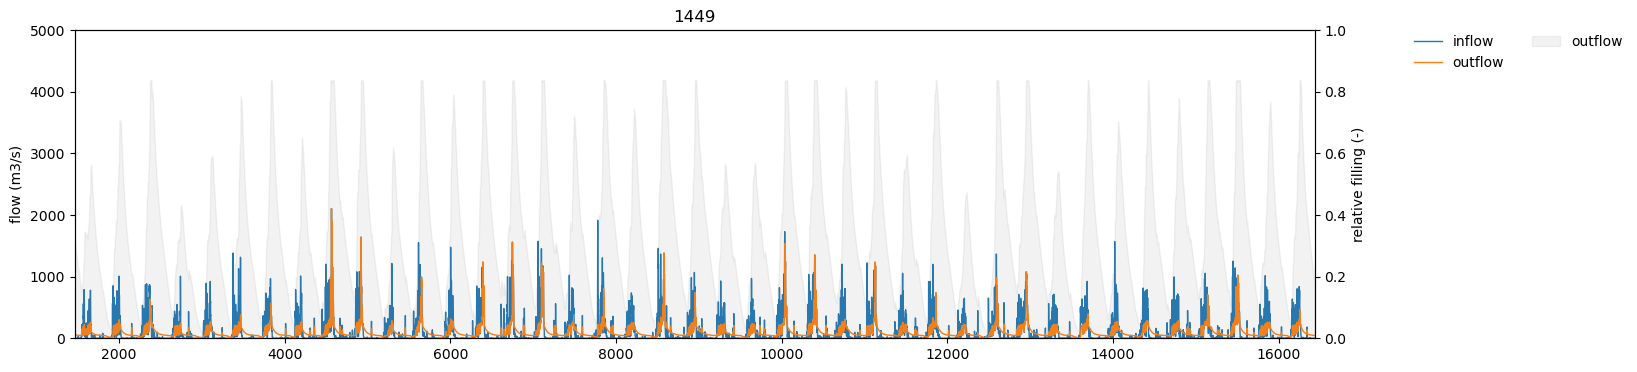

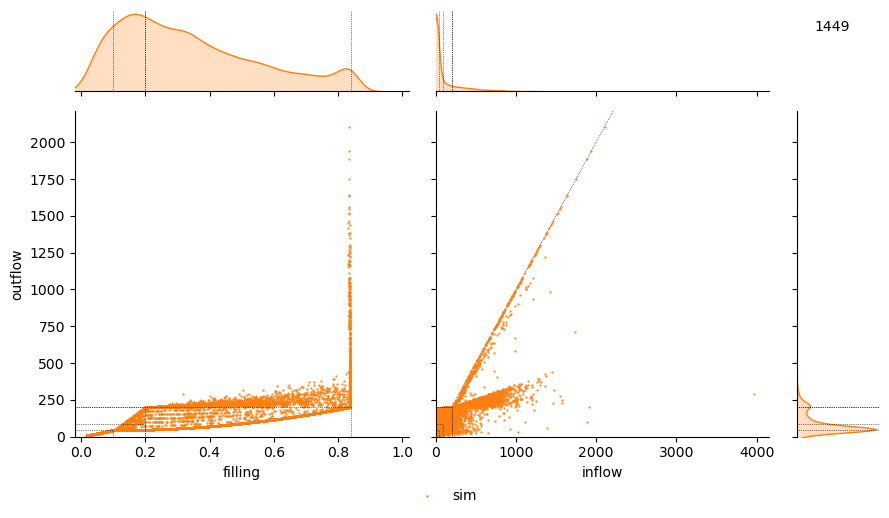

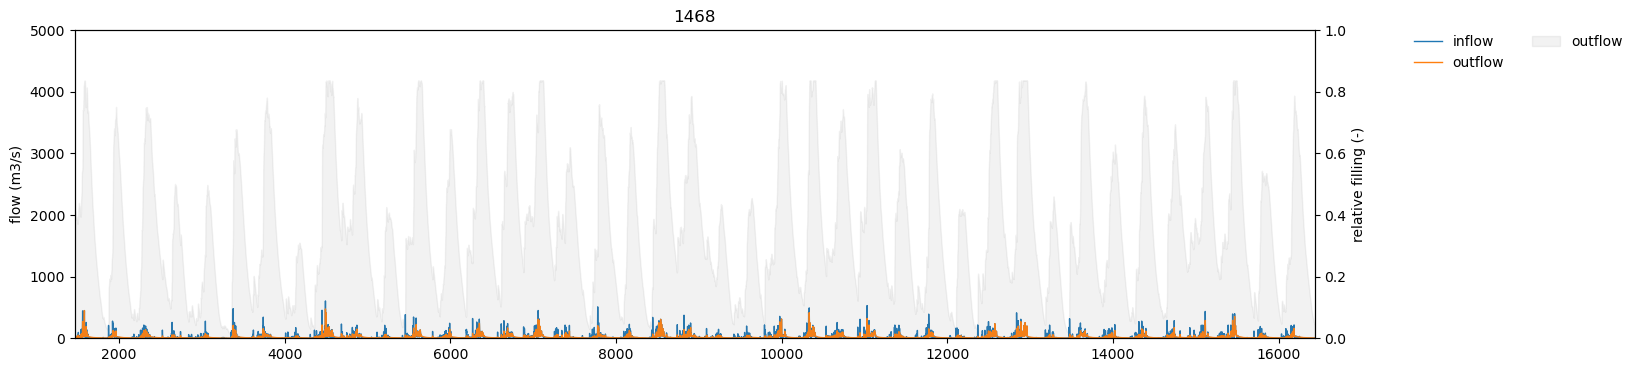

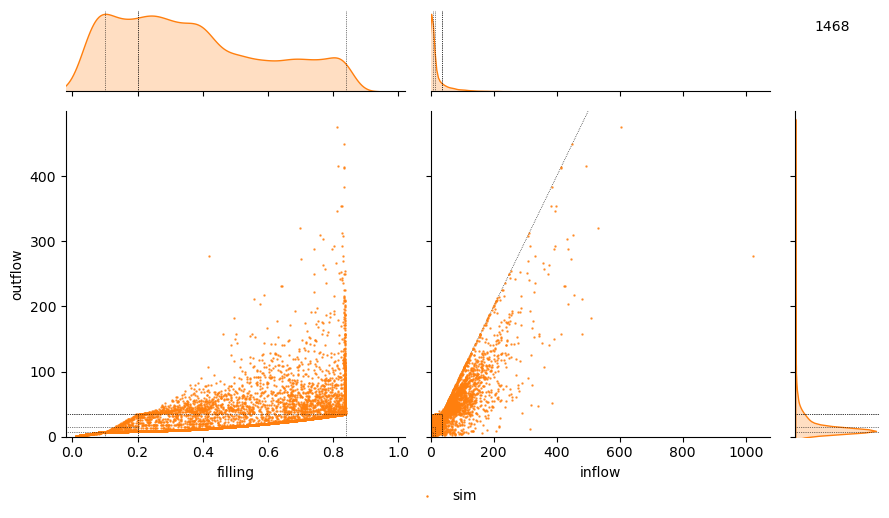

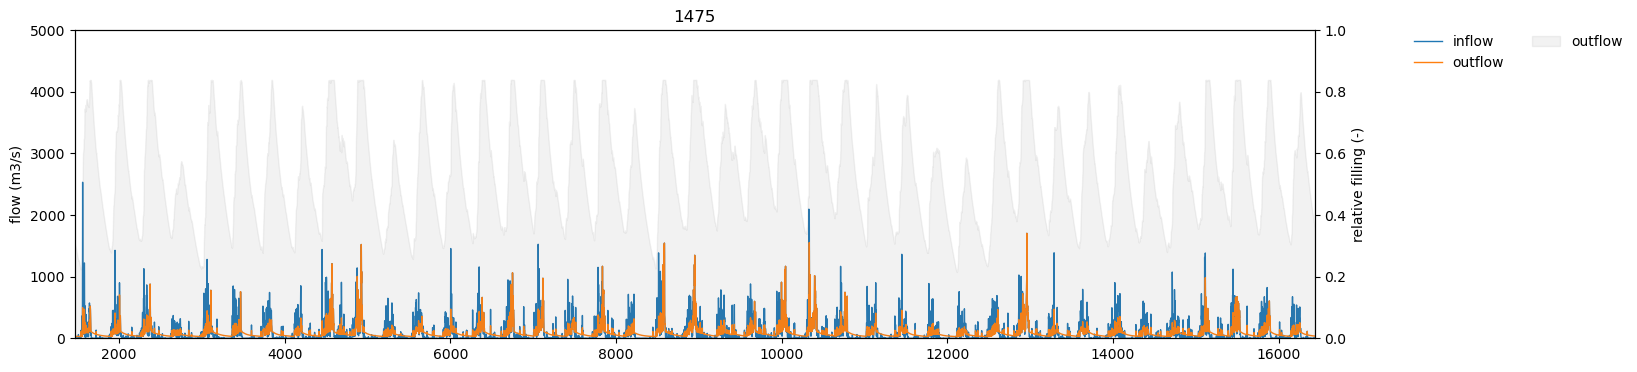

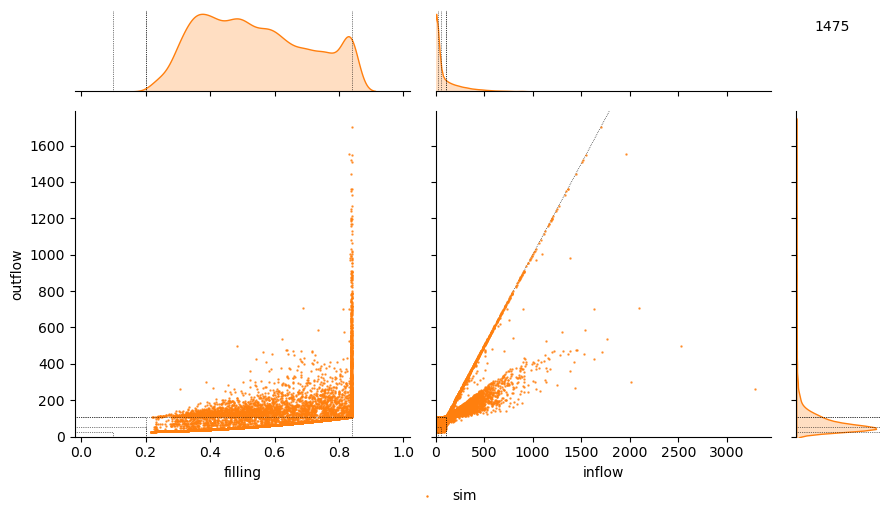

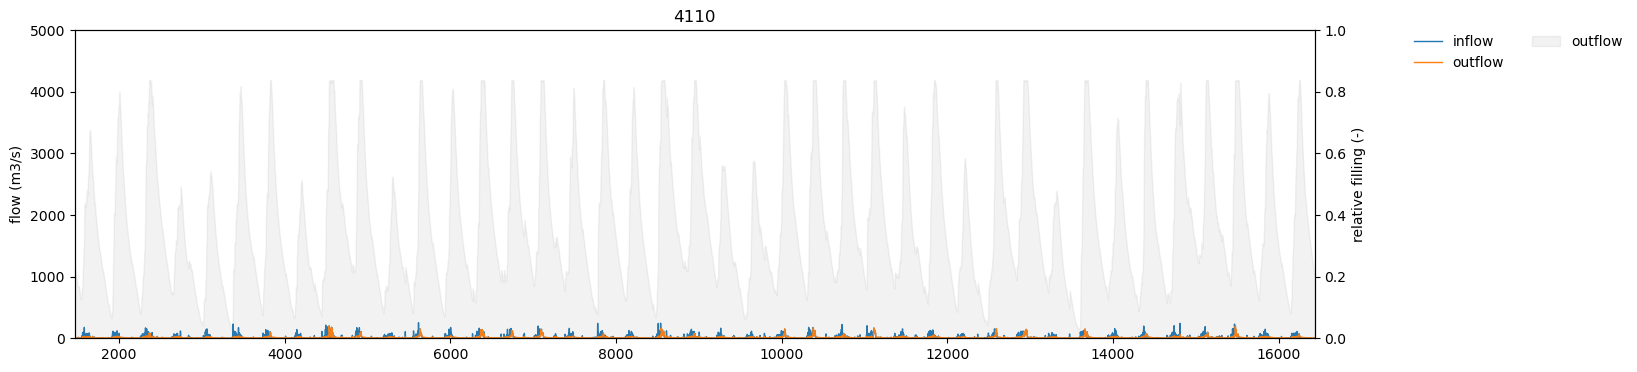

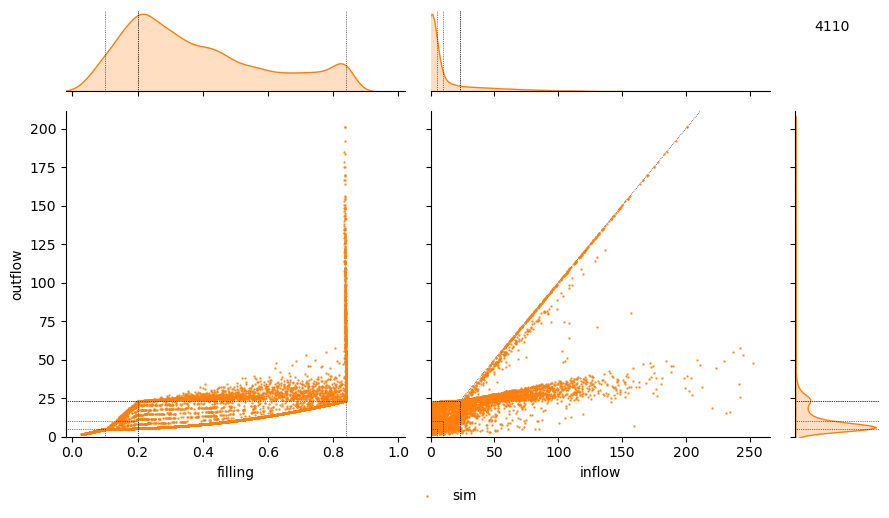

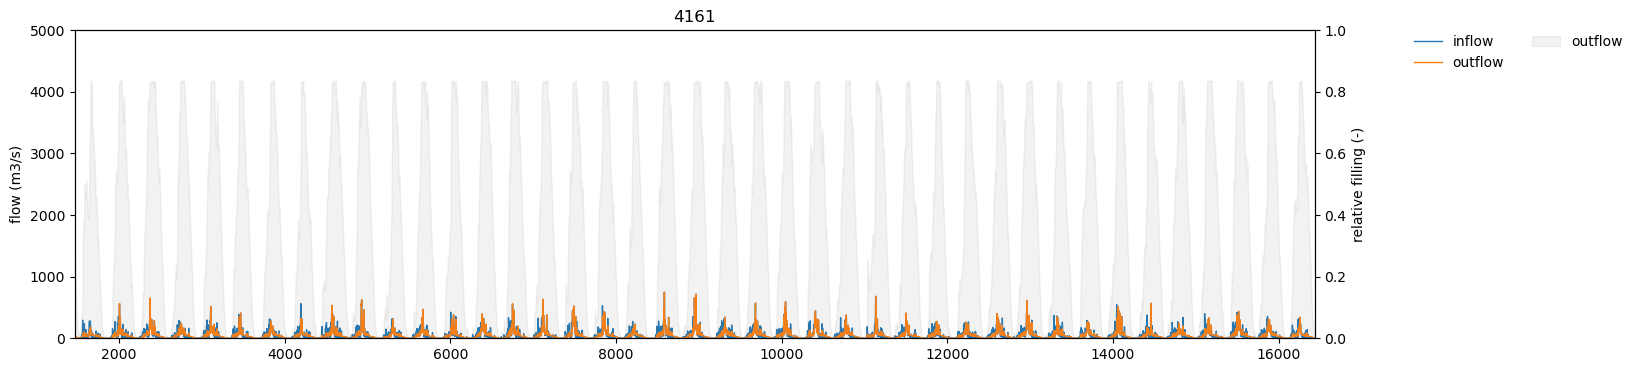

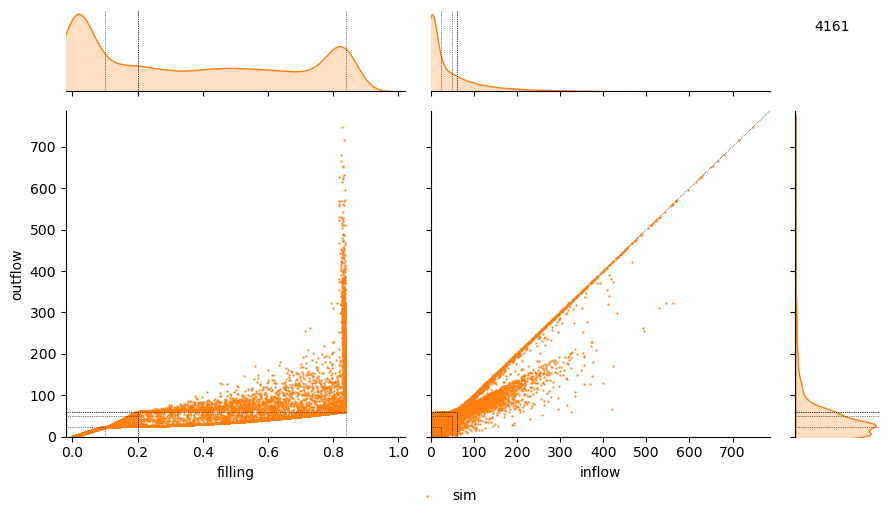

In [12]:
for ID, sim in results.items():
    plot_reservoir(
        sim,
        title=ID
    )
    reservoir_analysis(
        sim=sim,
        obs=None,
        x1='filling',
        x_thr=limits.loc[ID, ['Ve', 'Vf', 'Vf', 'Vc']],
        x2='inflow',
        y='outflow',
        y_thr=limits.loc[ID, ['Qf', 'Qf', 'Qn', 'Qc']],
        title=ID,
        alpha=.8
    )

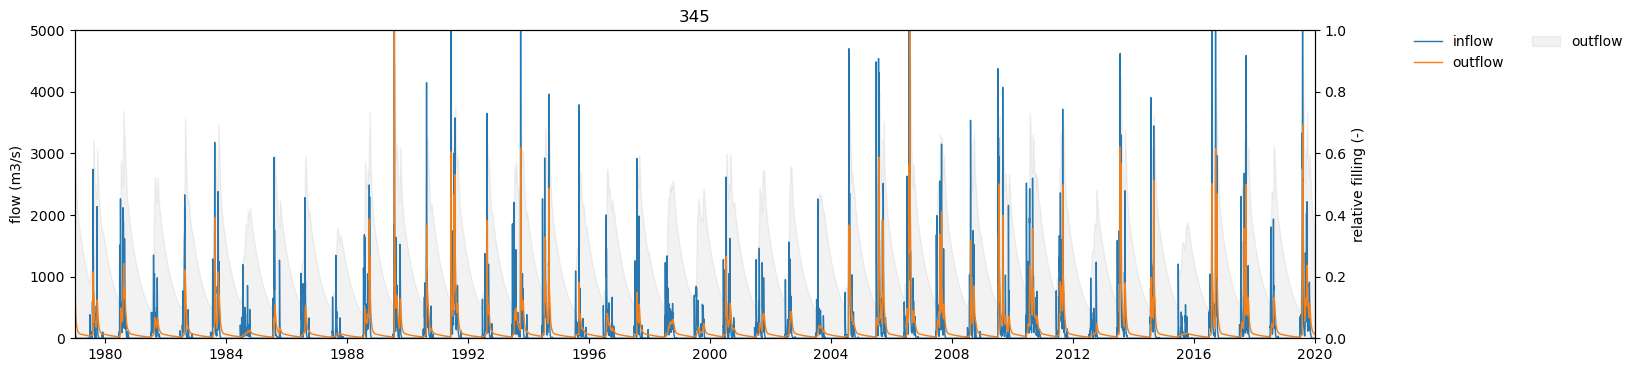

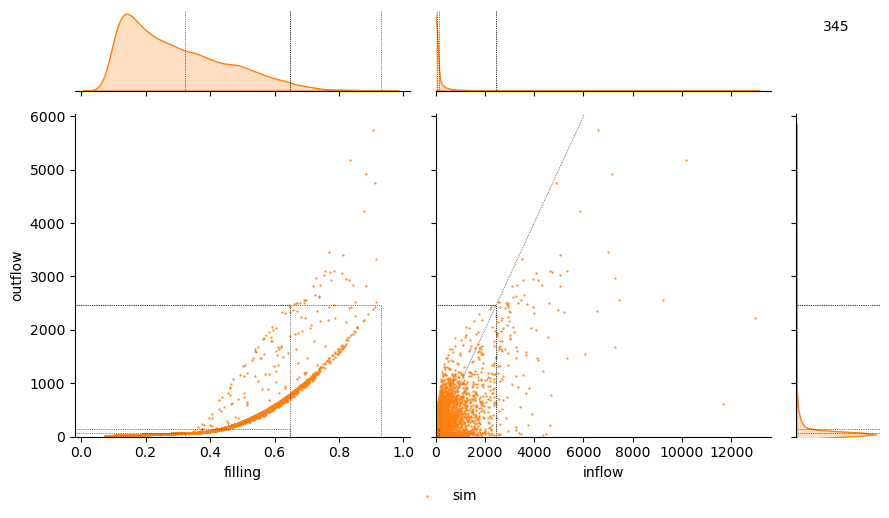

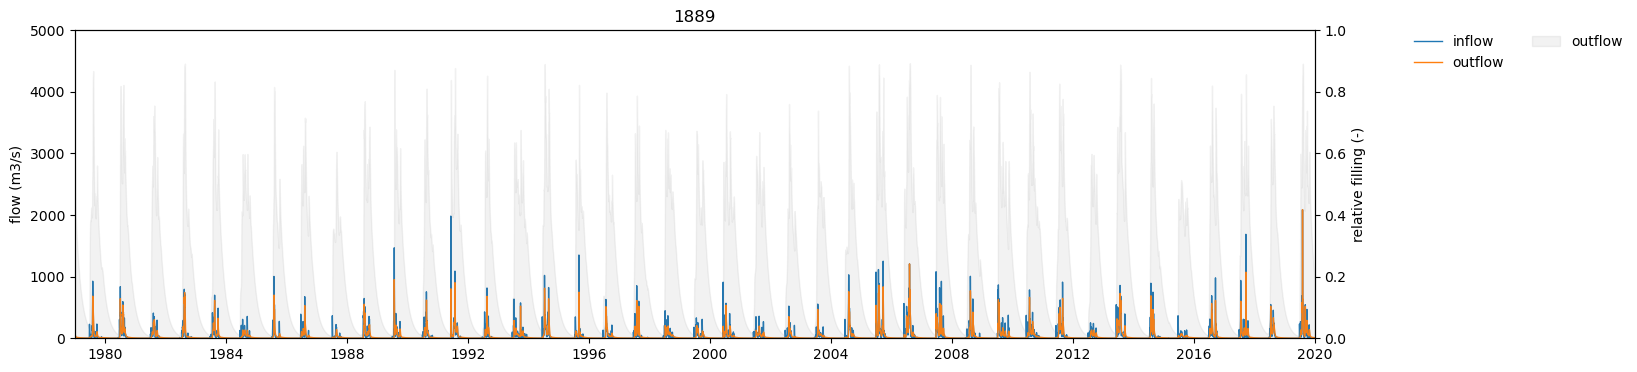

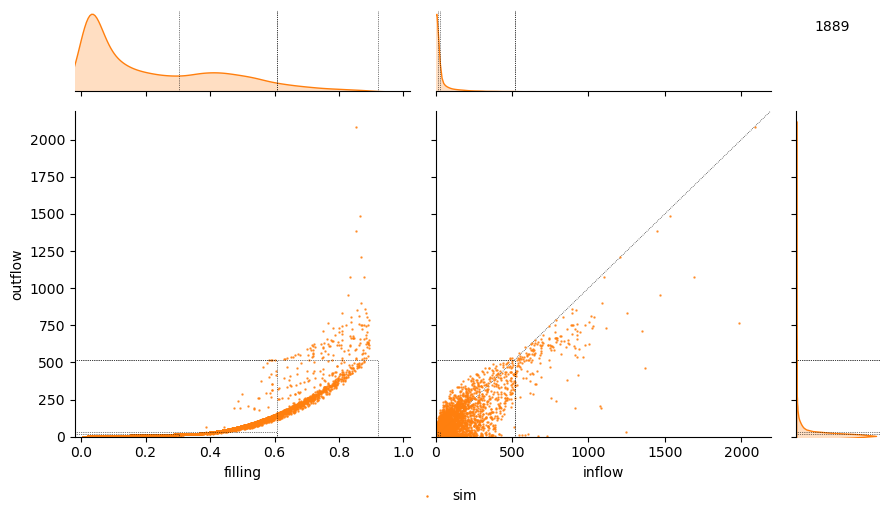

In [29]:
for ID, sim in results.items():
    plot_reservoir(sim, title=ID)
    if ID == 525:
        obs = observed
    else:
        obs = None
    reservoir_analysis(
        sim=sim,
        obs=obs,
        x1='filling',
        x_thr=limits.loc[ID, ['Ve', 'Vf', 'Vf', 'Vc']],
        x2='inflow',
        y='outflow',
        y_thr=limits.loc[ID, ['Qf', 'Qf', 'Qn', 'Qc']],
        title=ID,
        alpha=.8
    )

In [12]:
ID = 345
results[ID].inflow.min(), results[ID].outflow.min(), limits.loc[ID, 'Qmin']

(2.52051e-09, 8.43039, 6.769)